<a href="https://colab.research.google.com/github/TimTree/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
#!pip install pandas==0.25.1

In [2]:
# TODO - your code!
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-09-17 22:55:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.2’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.1s    

2019-09-17 22:55:43 (127 KB/s) - ‘house-votes-84.data.2’ saved [18171/18171]



In [3]:
import pandas as pd
import numpy as np
# Load Data
df = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [4]:
df = df.replace({'?': np.NaN, 'n': 0, 'y': 1})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
dem = df[df['party'] == 'democrat']
rep = df[df['party'] == 'republican']

In [6]:
dem.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [7]:
rep.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [8]:
import scipy.stats as stats

def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = np.std(data,ddof=1)/np.sqrt(n)
  margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  print(margin_of_error)
  return (mean, mean-margin_of_error, mean+margin_of_error)

confidence_interval(rep['water-project'].dropna())

0.08149104629696514


(0.5067567567567568, 0.42526571045979167, 0.5882478030537219)

**How many republicans support the water project issue?**

50.7% of them do, with a 8.1% margin of error. We're 95% sure that 42.6-58.8% of republicans support this issue.

0.08149104629696514


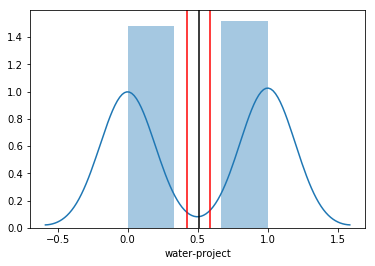

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(rep['water-project'].dropna())
CI = confidence_interval(rep['water-project'].dropna())
plt.axvline(x=CI[1],color='red')
plt.axvline(x=CI[2],color='red')
plt.axvline(x=CI[0],color='black')

**Chi Squared Test**

In [10]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv

--2019-09-17 22:55:45--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17574 (17K) [text/plain]
Saving to: ‘persons.csv.2’

persons.csv.2       100%[===================>]  17.16K  --.-KB/s    in 0.004s  

2019-09-17 22:55:45 (4.62 MB/s) - ‘persons.csv.2’ saved [17574/17574]



In [11]:
import pandas as pd
df = pd.read_csv("persons.csv")
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [12]:
df.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [13]:
df = df.loc[:,['weight','exercise_time']]
df.head()

,weight,exercise_time
0,118,192
1,161,35
2,128,220
3,216,57
4,116,182


In [14]:
weight_cut = pd.cut(df['weight'],5)
exercise_time_cut = pd.cut(df['exercise_time'],5)
weight_cut

0       (99.854, 129.2]
1        (158.4, 187.6]
2       (99.854, 129.2]
3        (187.6, 216.8]
4       (99.854, 129.2]
             ...       
1195     (187.6, 216.8]
1196     (187.6, 216.8]
1197     (129.2, 158.4]
1198     (129.2, 158.4]
1199     (129.2, 158.4]
Name: weight, Length: 1200, dtype: category
Categories (5, interval[float64]): [(99.854, 129.2] < (129.2, 158.4] < (158.4, 187.6] < (187.6, 216.8] <
                                    (216.8, 246.0]]

In [15]:
crosstab_weight_exercise = pd.crosstab(exercise_time_cut, weight_cut, margins=True)
crosstab_weight_exercise

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]",All
exercise_time,,,,,,
"(-0.3, 60.0]",53,44,61,76,44,278
"(60.0, 120.0]",65,76,93,73,9,316
"(120.0, 180.0]",71,67,56,29,0,223
"(180.0, 240.0]",79,74,38,1,0,192
"(240.0, 300.0]",107,74,10,0,0,191
All,375,335,258,179,53,1200


In [16]:
crosstab_weight_exercise

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]",All
exercise_time,,,,,,
"(-0.3, 60.0]",53,44,61,76,44,278
"(60.0, 120.0]",65,76,93,73,9,316
"(120.0, 180.0]",71,67,56,29,0,223
"(180.0, 240.0]",79,74,38,1,0,192
"(240.0, 300.0]",107,74,10,0,0,191
All,375,335,258,179,53,1200


In [0]:
oneHour = crosstab_weight_exercise.iloc[0][0:5].values
twoHours = crosstab_weight_exercise.iloc[1][0:5].values
threeHours = crosstab_weight_exercise.iloc[2][0:5].values
fourHours = crosstab_weight_exercise.iloc[3][0:5].values
fiveHours = crosstab_weight_exercise.iloc[4][0:5].values

In [28]:
oneHour

array([53, 44, 61, 76, 44])

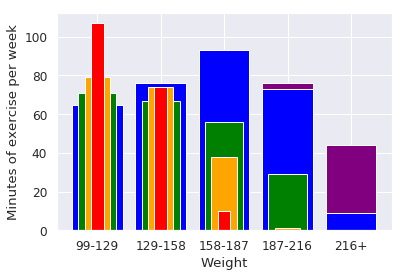

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
sns.set(font_scale=1.1)
categories = ["99-129","129-158","158-187","187-216","216+"]
p1 = plt.bar(categories, oneHour, color='purple')
p2 = plt.bar(categories, twoHours, 0.8, color='blue')
p2 = plt.bar(categories, threeHours, 0.6, color='green')
p2 = plt.bar(categories, fourHours, 0.4, color='orange')
p2 = plt.bar(categories, fiveHours, 0.2, color='red')
plt.xlabel('Weight')
plt.ylabel('Minutes of exercise per week')
plt.show()

In [48]:
row_sums = crosstab_weight_exercise.iloc[0:5, 5].values
col_sums = crosstab_weight_exercise.iloc[5, 0:5].values

print(row_sums)
print(col_sums)

[278 316 223 192 191]
[375 335 258 179  53]


In [50]:
total = crosstab_weight_exercise.loc['All','All']
total

1200

In [51]:
df.shape[0]

1200

In [52]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)


expected = np.array(expected)
print(expected.shape)
print(expected)

(5, 5)
[[86.875      77.60833333 59.77       41.46833333 12.27833333]
 [98.75       88.21666667 67.94       47.13666667 13.95666667]
 [69.6875     62.25416667 47.945      33.26416667  9.84916667]
 [60.         53.6        41.28       28.64        8.48      ]
 [59.6875     53.32083333 41.065      28.49083333  8.43583333]]


In [54]:
observed = pd.crosstab(exercise_time_cut, weight_cut).values
print(observed.shape)
observed

(5, 5)


array([[ 53,  44,  61,  76,  44],
       [ 65,  76,  93,  73,   9],
       [ 71,  67,  56,  29,   0],
       [ 79,  74,  38,   1,   0],
       [107,  74,  10,   0,   0]])

In [57]:
chi_squared = ((observed - expected)**2/(expected)).sum() 
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 344.201322954906


In [58]:
dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f"Degrees of Freedom: {dof}")

Degrees of Freedom: 16


In [59]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 344.201322954906
P-value: 1.6734133240537236e-63
Degrees of Freedom: 16
Expected: 
 [[86.875      77.60833333 59.77       41.46833333 12.27833333]
 [98.75       88.21666667 67.94       47.13666667 13.95666667]
 [69.6875     62.25416667 47.945      33.26416667  9.84916667]
 [60.         53.6        41.28       28.64        8.48      ]
 [59.6875     53.32083333 41.065      28.49083333  8.43583333]]


Null hypothesis: Weight is independent on hours of exercise per week.

Since the p-value is close to 0, we reject the null hypothesis and conclude that weight is indeed dependent on hours of exercise per week.

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)